In [197]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
import pickle
import pandas as pd
import rasterio

from GCCM_gao import run_GCCM, embedding
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [144]:
# Set specific font sizes
plt.rcParams.update({
    'font.size': 14,          # Global font size
    'axes.titlesize': 16,     # Title font size
    'axes.labelsize': 14,     # X and Y axis labels font size
    'xtick.labelsize': 11,    # X-axis tick labels font size
    'ytick.labelsize': 11,    # Y-axis tick labels font size
    'legend.fontsize': 11,    # Legend font size
})

## Data

In [2]:
# load data

x = rasterio.open('../Gao_code/raster/dTRI.tif')
xMatrix = x.read(1)
xMatrix = xMatrix.T
y = rasterio.open('../Gao_code/raster/Cu.tif')
yMatrix = y.read(1)
yMatrix = yMatrix.T

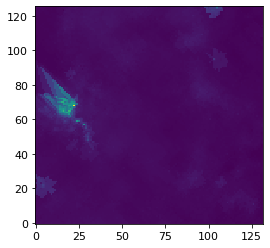

In [145]:
plt.imshow(yMatrix, origin='lower', interpolation='none')

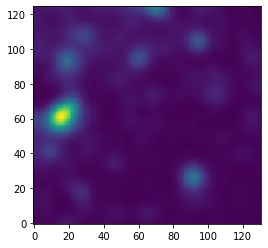

In [3]:
plt.imshow(xMatrix, origin='lower', interpolation='none')

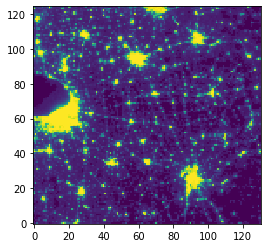

In [112]:
z = rasterio.open('../Gao_code/raster/nlights03.tif')
zMatrix = z.read(1)
zMatrix = zMatrix.T
zMatrix = zMatrix.astype(float)
plt.imshow(zMatrix, origin='lower', interpolation='none')

In [113]:
xEmbedings = embedding(xMatrix, E)
yEmbedings = embedding(yMatrix, E)
zEmbedings = embedding(zMatrix, E)

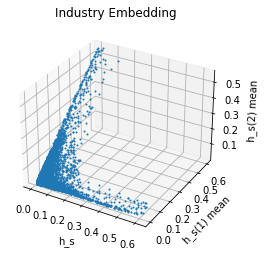

In [121]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(xEmbedings[0].flatten(),np.mean(xEmbedings[1], axis=1),np.mean(xEmbedings[2], axis=1), '.', ms=2 )
#ax.plot(xEmbedings[0].flatten(),np.max(xEmbedings[1], axis=1), np.max(xEmbedings[2], axis=1), '.', ms=2 )
#ax.plot(xEmbedings[0].flatten(),xEmbedings[1][:,-1],xEmbedings[2][:,-1], '.' )
#ax.plot(np.mean(xEmbedings[2], axis=1),np.mean(xEmbedings[1], axis=1),xEmbedings[0].flatten(), '.' )
#ax.plot(np.mean(xEmbedings[1], axis=1),np.mean(xEmbedings[2], axis=1),np.mean(xEmbedings[3], axis=1), '.' )
ax.set_xlabel("h_s")
ax.set_ylabel("h_s(1) mean")
ax.set_zlabel("h_s(2) mean")
ax.set_title("Industry Embedding")

plt.show()

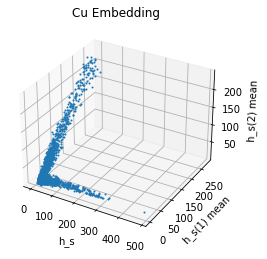

In [114]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(yEmbedings[0].flatten(),np.mean(yEmbedings[1], axis=1),np.mean(yEmbedings[2], axis=1), '.', ms=2 )
#ax.plot(yEmbedings[0].flatten(),yEmbedings[1][:,3],yEmbedings[2][:,3], '.' )

#ax.plot(np.mean(yEmbedings[1], axis=1),np.mean(yEmbedings[2], axis=1),np.mean(yEmbedings[3], axis=1), '.' )
ax.set_xlabel("h_s")
ax.set_ylabel("h_s(1) mean")
ax.set_zlabel("h_s(2) mean")
ax.set_title("Cu Embedding")

plt.show()

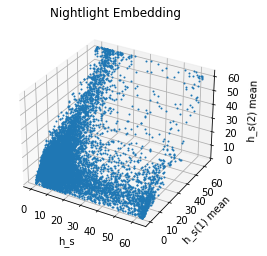

In [115]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(zEmbedings[0].flatten(),np.mean(zEmbedings[1], axis=1),np.mean(zEmbedings[2], axis=1), '.', ms=2 )
#ax.plot(zEmbedings[0].flatten(),zEmbedings[1][:,3],zEmbedings[2][:,3], '.' )

#ax.plot(np.mean(zEmbedings[1], axis=1),np.mean(zEmbedings[2], axis=1),np.mean(zEmbedings[3], axis=1), '.' )
ax.set_xlabel("h_s")
ax.set_ylabel("h_s(1) mean")
ax.set_zlabel("h_s(2) mean")
ax.set_title("Nightlight Embedding")

plt.show()

In [127]:
lib_sizes = np.arange(10,120,20)

## Gao results reproduced in python

In [170]:
# Load the results from file
# python results
with open('gao/Iresults.pkl', 'rb') as pickle_file:
    iresults = pickle.load(pickle_file)
with open('gao/Nresults.pkl', 'rb') as pickle_file:
    nresults = pickle.load(pickle_file)
# R results
iresultsr = pd.read_csv('../Gao_code/raster/results/Iresults.csv')

In [171]:
ix_xmap_y = []
iy_xmap_x = []
for lib in lib_sizes:
    ix_xmap_y.append(iresults['x_xmap_y'][lib]['mean'])
    iy_xmap_x.append(iresults['y_xmap_x'][lib]['mean'])
nx_xmap_y = []
ny_xmap_x = []
for lib in lib_sizes:
    nx_xmap_y.append(nresults['x_xmap_y'][lib]['mean'])
    ny_xmap_x.append(nresults['y_xmap_x'][lib]['mean'])

**x cause**: Industry or Nightlight \
**y effect**: Cu

x xmap y embedding of x variable to predict y (information in x can predict y) so y (Cu) -> x (Industry) \
y xmap x embedding of y variable to predict x (information in  effect y can predict cause x) so x (Industry) -> y (Cu)

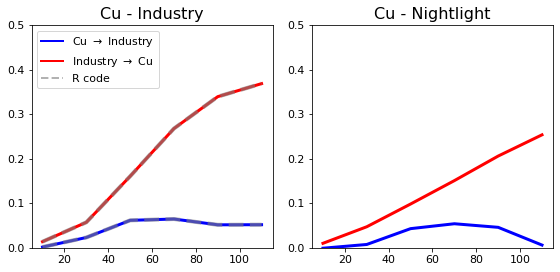

In [191]:
# Appendix figure
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(lib_sizes, ix_xmap_y, c='b', lw=3, label = r'Cu $\rightarrow$ Industry')
ax[0].plot(lib_sizes, iy_xmap_x, c='r', lw=3, label = r'Industry $\rightarrow$ Cu')

ax[0].plot(lib_sizes, list(iresultsr['x_xmap_y_means']), '--', c='grey', alpha=0.6, lw=4, label='R code')
ax[0].plot(lib_sizes, list(iresultsr['y_xmap_x_means']), '--', c='grey', alpha=0.6, lw=4)
ax[0].set_ylim(0,0.5)
ax[0].set_title('Cu - Industry')
legend = ax[0].legend()
for legobj in legend.legendHandles:
    legobj.set_linewidth(2)
    
ax[1].plot(lib_sizes, nx_xmap_y, c='b', lw=3)
ax[1].plot(lib_sizes, ny_xmap_x, c='r', lw=3)
ax[1].set_ylim(0,0.5)
ax[1].set_title('Cu - Nightlight')
ax[1].set_ylim(0,0.5)

plt.tight_layout()
plt.show()

## Corrected results

In [168]:
iresultsr_correct = pd.read_csv('../Gao_code/raster_corrected/results/Iresults_corrected.csv')

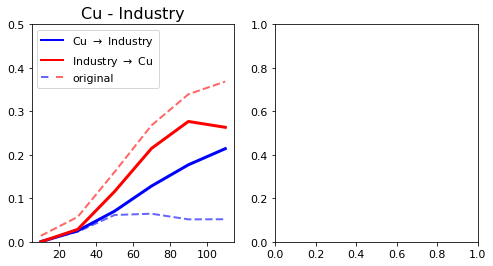

In [209]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
p1,= ax[0].plot(lib_sizes, list(iresultsr['x_xmap_y_means']), '--', c='b', alpha=0.6, lw=2, label='original')
p2,= ax[0].plot(lib_sizes, list(iresultsr['y_xmap_x_means']), '--', c='r', alpha=0.6, lw=2)
p3,= ax[0].plot(lib_sizes, list(iresultsr_correct['x_xmap_y_means']),  c='b',  lw=3, label = r'Cu $\rightarrow$ Industry')
p4,= ax[0].plot(lib_sizes, list(iresultsr_correct['y_xmap_x_means']),  c='r',  lw=3, label = r'Industry $\rightarrow$ Cu')
ax[0].set_ylim(0,0.5)
ax[0].set_title('Cu - Industry')
#legend = ax[0].legend()

# Assign two of the handles to the same legend entry by putting them in a tuple
# and using a generic handler map (which would be used for any additional
# tuples of handles like (p1, p2)).
legend = ax[0].legend([p3, p4, (p1, p2)], [r'Cu $\rightarrow$ Industry', r'Industry $\rightarrow$ Cu', 'original'], scatterpoints=1,
               numpoints=1, markerscale=1., handler_map={tuple: HandlerTuple(ndivide=None, pad=0.7)})
for legobj in legend.legendHandles:
    legobj.set_linewidth(2)